# Political Bias Classification with BERT

This notebook trains a XLM-RoBERTa model to classify political bias in news articles.

## Experimental Setup
- **Training Data**: AllSides balanced news headlines dataset (~21K samples)
  - Shorter texts (headlines + snippets)
  - Labels: left, center, right
- **Test Data**: Gold OpenAI annotations (300 samples)
  - Longer texts (multiple snippets)
  - Labels: Left, Center, Right
  
This setup tests if a model trained on shorter texts can generalize to longer, more complex articles.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


## 2. Load and Explore Training Dataset (AllSides)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Correct file path inside Google Drive
file_path = "/content/drive/MyDrive/NLP_Project_Dataset/allsides_balanced_news_headlines-texts.csv"

# Load AllSides training data
train_df = pd.read_csv(file_path)

print(f"Training dataset shape: {train_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(train_df.head(3))
print(f"\nBias rating distribution:")
print(train_df['bias_rating'].value_counts())
print(f"\nMissing values:")
print(train_df.isnull().sum())

# Check text length
train_df['text_length'] = train_df['text'].fillna('').str.len()
print(f"\nText length statistics (AllSides):")
print(train_df['text_length'].describe())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training dataset shape: (21754, 7)

Columns: ['Unnamed: 0', 'title', 'tags', 'heading', 'source', 'text', 'bias_rating']

First 3 rows:
   Unnamed: 0                                     title  \
0           0  Gun Violence Over Fourth of July Weekend   
1           1  Gun Violence Over Fourth of July Weekend   
2           2  Gun Violence Over Fourth of July Weekend   

                                                tags  \
0  ['Protests', 'Fourth Of July', 'Gun Control An...   
1  ['Protests', 'Fourth Of July', 'Gun Control An...   
2  ['Protests', 'Fourth Of July', 'Gun Control An...   

                                             heading                 source  \
0  Chicago Gun Violence Spikes and Increasingly F...  New York Times (News)   
1  ‘Bullets just came from nowhere’: Fourth of Ju...        Chicago Tribune   
2  Dozens of shootings across US mar

Once the file is uploaded, you can re-run the cell where the error occurred to proceed.

## 3. Load and Explore Test Dataset (Gold OpenAI)

In [3]:

# Correct file path inside Google Drive
test_file_path = "/content/drive/MyDrive/NLP_Project_Dataset/gold_openai_annotations_all_batches_1_30.csv"

# Load Gold OpenAI test data
test_df = pd.read_csv(test_file_path)

print(f"Test dataset shape: {test_df.shape}")
print(f"\nColumns: {test_df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(test_df[['docid', 'title', 'ManualBiasLabel']].head(3))
print(f"\nManualBiasLabel distribution:")
print(test_df['ManualBiasLabel'].value_counts())
print(f"\nMissing values:")
print(test_df.isnull().sum())

# Combine snippets into text
test_df['text'] = (
    test_df['snippet1'].fillna('') + ' ' +
    test_df['snippet2'].fillna('') + ' ' +
    test_df['snippet3'].fillna('')
).str.strip()

test_df['text_length'] = test_df['text'].str.len()
print(f"\nText length statistics (Gold OpenAI):")
print(test_df['text_length'].describe())


Test dataset shape: (300, 12)

Columns: ['docid', 'title', 'snippet1', 'snippet2', 'snippet3', 'Q1_score', 'Q2_score', 'Q3_reason', 'other_text', 'ManualBiasLabel', 'outletLabel', 'Correct']

First 3 rows:
                                  docid  \
0  71b2d99c-b584-4f52-a4a8-f5438bb1c19e   
1  340bccc6-4647-431e-9a18-d133f755739b   
2  37cfca80-28db-4b6a-8f62-d3d2e7500b9d   

                                               title ManualBiasLabel  
0  Trump slams FBI raid of lawyer Michael Cohen: ...            Left  
1  Ohio State Fake News Study Doesn’t Say What Th...           Right  
2  Trump says the military will secure the southe...            Left  

ManualBiasLabel distribution:
ManualBiasLabel
Left      147
Right     129
Center     24
Name: count, dtype: int64

Missing values:
docid                0
title                0
snippet1             0
snippet2             0
snippet3             1
Q1_score             0
Q2_score             0
Q3_reason            0
other_text         30

## 4. Preprocess Training Data (AllSides)

Standardize labels to match: `Left`, `Center`, `Right`

In [4]:
# Standardize labels: left -> Left, center -> Center, right -> Right
train_df['ManualBiasLabel'] = train_df['bias_rating'].str.capitalize()

# Remove rows with missing text
train_df = train_df[train_df['text'].notna()].copy()
train_df = train_df[train_df['text'].str.len() > 10].copy()  # Remove very short texts

print(f"Training data after cleaning: {train_df.shape}")
print(f"Label distribution:")
print(train_df['ManualBiasLabel'].value_counts())

# Split into train and validation
train_data, val_data = train_test_split(
    train_df[['text', 'ManualBiasLabel']],
    test_size=0.2,
    stratify=train_df['ManualBiasLabel'],
    random_state=42
)

print(f"\nTrain split: {train_data.shape}")
print(f"Validation split: {val_data.shape}")

Training data after cleaning: (21744, 9)
Label distribution:
ManualBiasLabel
Left      10272
Right      7220
Center     4252
Name: count, dtype: int64

Train split: (17395, 2)
Validation split: (4349, 2)


## 5. Preprocess Test Data (Gold OpenAI)

Ensure the test data has the same label format and remove any missing values.

In [5]:
# Test data already has 'text' column created and ManualBiasLabel
test_data = test_df[['text', 'ManualBiasLabel']].copy()

# Remove rows with missing text
test_data = test_data[test_data['text'].notna()].copy()
test_data = test_data[test_data['text'].str.len() > 10].copy()

print(f"Test data after cleaning: {test_data.shape}")
print(f"Label distribution:")
print(test_data['ManualBiasLabel'].value_counts())

Test data after cleaning: (300, 2)
Label distribution:
ManualBiasLabel
Left      147
Right     129
Center     24
Name: count, dtype: int64


## 6. Encode Labels

Use `LabelEncoder` to convert text labels to integers consistently across train, val, and test sets.

In [6]:
# Fit label encoder on training data
label_encoder = LabelEncoder()
train_data['labels'] = label_encoder.fit_transform(train_data['ManualBiasLabel'])
val_data['labels'] = label_encoder.transform(val_data['ManualBiasLabel'])
test_data['labels'] = label_encoder.transform(test_data['ManualBiasLabel'])

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print(f"\nNumber of classes: {len(label_encoder.classes_)}")

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_data[['text', 'labels']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_data[['text', 'labels']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_data[['text', 'labels']].reset_index(drop=True))

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

Label mapping: {'Center': np.int64(0), 'Left': np.int64(1), 'Right': np.int64(2)}

Number of classes: 3

Dataset sizes:
  Train: 17395
  Val: 4349
  Test: 300


## 7. Load Tokenizer and Model

Using XLM-RoBERTa base for multilingual and robust text classification.

In [7]:
model_name = "FacebookAI/xlm-roberta-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
)

print(f"Model loaded: {model_name}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: FacebookAI/xlm-roberta-base
Number of parameters: 278,045,955


## 8. Tokenize Datasets

Tokenize all text data with padding and truncation to max_length of 256 tokens.

In [8]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Tokenize all datasets
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

print("Tokenization complete!")
print(f"Train dataset columns: {train_dataset.column_names}")

Map:   0%|          | 0/17395 [00:00<?, ? examples/s]

Map:   0%|          | 0/4349 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenization complete!
Train dataset columns: ['text', 'labels', 'input_ids', 'attention_mask']


## 9. Define Evaluation Metrics

Compute accuracy and macro-averaged F1 score for model evaluation.

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

## 10. Configure Training Arguments

Set up hyperparameters for training with the Hugging Face Trainer.

In [10]:
training_args = TrainingArguments(
    output_dir="./allsides_trained_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none",
    save_total_limit=2,
    fp16=True,
    optim="adamw_torch",
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2

)

print("Training configuration:")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Output directory: {training_args.output_dir}")

Training configuration:
  Batch size: 16
  Learning rate: 3e-05
  Epochs: 10
  Output directory: ./allsides_trained_model


# For Baseline

In [11]:
# 11. Baseline Evaluation (Pre-Fine-Tuning)
# Evaluate the XLM-RoBERTa model before any fine-tuning

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np

print("\n==== BASELINE EVALUATION (unfine-tuned model) ====")

# Use a separate Trainer instance for baseline evaluation
baseline_trainer = Trainer(
    model=model,                 # this is the pre-trained, NOT yet fine-tuned model
    args=training_args,
    eval_dataset=val_dataset,    # we’ll first evaluate on the validation set
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

# 1) Validation metrics (before training)
baseline_val_results = baseline_trainer.evaluate()
print("\n[BASELINE] Validation metrics:")
for key, value in baseline_val_results.items():
    print(f"  {key}: {value:.4f}")

# 2) Test metrics + detailed report (before training)
baseline_test_predictions = baseline_trainer.predict(test_dataset)
baseline_test_logits = baseline_test_predictions.predictions
baseline_test_labels = baseline_test_predictions.label_ids
baseline_test_preds = np.argmax(baseline_test_logits, axis=1)

baseline_test_acc = accuracy_score(baseline_test_labels, baseline_test_preds)
baseline_test_f1 = f1_score(baseline_test_labels, baseline_test_preds, average="macro")

print("\n[BASELINE] Test metrics (Gold OpenAI):")
print(f"  accuracy:  {baseline_test_acc:.4f}")
print(f"  f1_macro:  {baseline_test_f1:.4f}")

print("\n[BASELINE] Test classification report:")
print(classification_report(
    baseline_test_labels,
    baseline_test_preds,
    target_names=label_encoder.classes_
))

print("[BASELINE] Test confusion matrix:")
print(confusion_matrix(baseline_test_labels, baseline_test_preds))

print("\n==== End of BASELINE evaluation ====\n")



==== BASELINE EVALUATION (unfine-tuned model) ====



[BASELINE] Validation metrics:
  eval_loss: 1.1408
  eval_model_preparation_time: 0.0033
  eval_accuracy: 0.1954
  eval_f1_macro: 0.1090
  eval_runtime: 6.6543
  eval_samples_per_second: 653.5650
  eval_steps_per_second: 40.8760

[BASELINE] Test metrics (Gold OpenAI):
  accuracy:  0.0800
  f1_macro:  0.0494

[BASELINE] Test classification report:
              precision    recall  f1-score   support

      Center       0.08      1.00      0.15        24
        Left       0.00      0.00      0.00       147
       Right       0.00      0.00      0.00       129

    accuracy                           0.08       300
   macro avg       0.03      0.33      0.05       300
weighted avg       0.01      0.08      0.01       300

[BASELINE] Test confusion matrix:
[[ 24   0   0]
 [147   0   0]
 [129   0   0]]

==== End of BASELINE evaluation ====



## CM For baseline

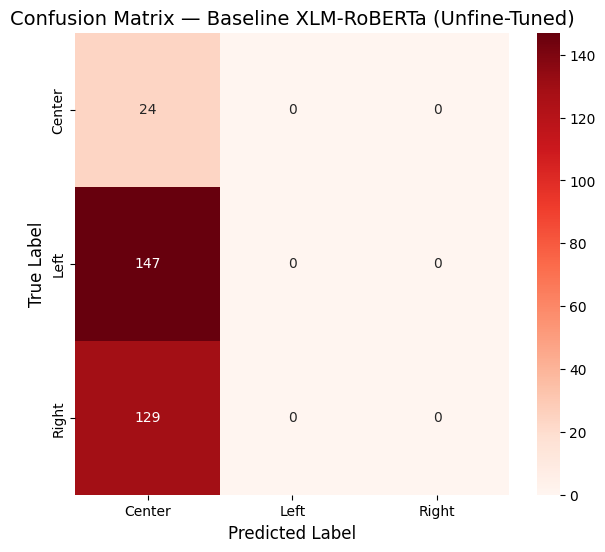

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm_baseline = confusion_matrix(baseline_test_labels, baseline_test_preds)
class_names = label_encoder.classes_  # ['Center', 'Left', 'Right']

# Plot heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Confusion Matrix — Baseline XLM-RoBERTa (Unfine-Tuned)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()


## 11. Initialize Trainer and Start Training

Create the Trainer and begin fine-tuning on the AllSides dataset.

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

print("Starting training...")
print(f"Training on {len(train_dataset)} samples")
print(f"Validating on {len(val_dataset)} samples")
print("-" * 50)

# Train the model
trainer.train()

print("\nTraining complete!")

Starting training...
Training on 17395 samples
Validating on 4349 samples
--------------------------------------------------


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.027200,1.007590,0.475282,0.221174
2,0.963600,0.948639,0.548632,0.468559
3,0.888300,0.904120,0.577374,0.494256
4,0.811400,0.907253,0.582433,0.527371
5,0.731800,0.943242,0.589561,0.563723
6,0.599500,1.063200,0.561508,0.538640
7,0.487800,1.181117,0.572086,0.550518
8,0.386300,1.438921,0.549322,0.536530
9,0.317600,1.550474,0.553001,0.540367
10,0.260500,1.633690,0.555300,0.539670



Training complete!


## 12. Evaluate on Test Set (Gold OpenAI)

Now evaluate the model trained on AllSides data against the Gold OpenAI test set.

In [14]:
print("Evaluating on Gold OpenAI test set...")
test_results = trainer.evaluate(test_dataset)

print("\n" + "="*50)
print("TEST SET RESULTS (Gold OpenAI)")
print("="*50)
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

Evaluating on Gold OpenAI test set...



TEST SET RESULTS (Gold OpenAI)
eval_loss: 1.2765
eval_accuracy: 0.4800
eval_f1_macro: 0.3779
eval_runtime: 0.4754
eval_samples_per_second: 631.0290
eval_steps_per_second: 39.9650
epoch: 10.0000


## 13. Generate Predictions and Confusion Matrix

Get detailed per-class performance metrics.

In [15]:
# Get predictions
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# Confusion matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(labels, preds)
print(cm)

# Classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(labels, preds, target_names=label_encoder.classes_))


CONFUSION MATRIX
[[ 3  6 15]
 [15 56 76]
 [10 34 85]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Center       0.11      0.12      0.12        24
        Left       0.58      0.38      0.46       147
       Right       0.48      0.66      0.56       129

    accuracy                           0.48       300
   macro avg       0.39      0.39      0.38       300
weighted avg       0.50      0.48      0.47       300



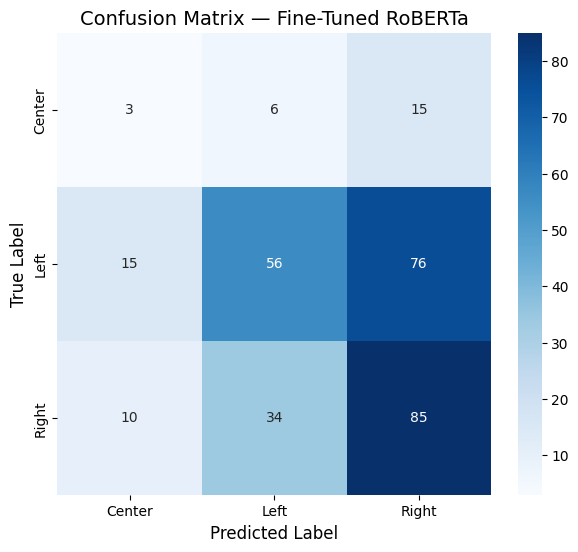

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your confusion matrix (already computed)
cm = confusion_matrix(labels, preds)
class_names = label_encoder.classes_   # ['Center', 'Left', 'Right']

# --- PLOT CONFUSION MATRIX ---
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Confusion Matrix — Fine-Tuned RoBERTa", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()


## 14. Analysis and Observations

### Key Findings:
- **Training Set (AllSides)**: ~21K samples with shorter texts
- **Test Set (Gold OpenAI)**: 300 samples with longer, more complex texts

### Expected Challenges:
1. **Domain Shift**: Training on shorter headline-style texts vs testing on longer article snippets
2. **Text Length Mismatch**: AllSides texts are typically shorter than Gold OpenAI texts
3. **Class Imbalance**: Both datasets have imbalanced classes, but distributions differ

### Improvements to Try:
- Add more training data or use data augmentation
- Experiment with different max_length settings (longer context)
- Try class weighting to handle imbalance
- Fine-tune on a mix of both short and long texts
- Use domain adaptation techniques

## 15. Save the Model (Optional)

Uncomment to save the trained model for later use.

In [17]:
# Uncomment to save the model and tokenizer
# model.save_pretrained("./final_bias_classifier")
# tokenizer.save_pretrained("./final_bias_classifier")
# print("Model saved to ./final_bias_classifier")

print("Notebook complete! Review the results above.")

Notebook complete! Review the results above.
